<a href="https://colab.research.google.com/github/nitingarg2015/EVA8/blob/master/Assignment%208/Assignment_8_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install required libraries/ packages

In [ ]:

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.optim.lr_scheduler import StepLR # Import your choice of scheduler here
import albumentations as A
from albumentations.pytorch import ToTensorV2

%matplotlib inline
from torch.utils.data import DataLoader


In [ ]:
#install torchsummary and torch-lr-finder if required

try:
    from torchsummary import summary
except ImportError:
    !pip install torchsummary
    from torchsummary import summary

try:
    from torch_lr_finder import LRFinder, TrainDataLoaderIter, ValDataLoaderIter
except ImportError:
    !pip install torch-lr-finder
    from torch_lr_finder import LRFinder

!pip install grad-cam

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Clone model, utility and other files from Git repository

In [ ]:
!git clone  https://github.com/nitingarg2015/Refs.git

Cloning into 'Refs'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 74 (delta 39), reused 57 (delta 24), pack-reused 0
Unpacking objects: 100% (74/74), 17.48 KiB | 1.03 MiB/s, done.


## Import and load Resnet18 model

In [ ]:
from Refs.models import custom_resnet

model = custom_resnet.cusResNet(dropout = 0.1)
model

CustomResNet(
  (conv): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout2d(p=0.1, inplace=False)
  )
  (layer1): LayeredBlock(
    (transition_block): TransitionBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.1, inplace=False)
    )
    (convb1): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.1, inplace=False)
    )
    (convb2): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size

In [ ]:
summary(model.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         Dropout2d-3           [-1, 64, 32, 32]               0
         ConvBlock-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
         Dropout2d-8          [-1, 128, 16, 16]               0
   TransitionBlock-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
        Dropout2d-12          [-1, 128, 16, 16]               0
        ConvBlock-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

## Load CIFAR train and test data loaders

In [ ]:
#import load_CIFAR_dataloader

from Refs.utils import CIFARdata 

#set batch size
batch_size = 512

#load training dataset
classes, train_loader = CIFARdata.load_CIFAR_dataloader(train = True, transform = True, batch_size = batch_size)
#load test dataset
_, test_loader = CIFARdata.load_CIFAR_dataloader(train = False, transform = False, batch_size = batch_size)

len(train_loader), len(test_loader)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


(98, 20)

## View sample images

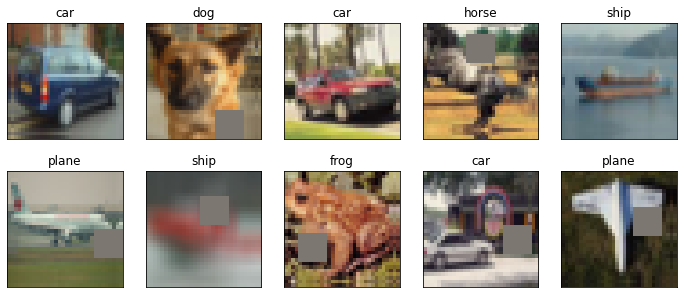

In [ ]:
# get some random training images
from Refs.utils import utils

import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))

no_images = 10

figure = plt.figure(figsize=(12, 5))

for index in range(1, no_images + 1):
    plt.subplot(2, 5, index)
    utils.imshow(images[index - 1])
    plt.tick_params(left=False, right=False, labelleft=False,
                    labelbottom=False, bottom=False)
    title = str(classes[labels[index - 1]])
    plt.title(title)


## Find Learning Rate Range

Files already downloaded and verified


  0%|          | 0/100 [00:00<?, ?it/s]

/content/Refs/models/custom_resnet.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.64E-01


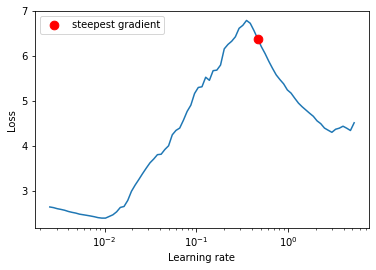

Max LR is 0.010235310218990263


In [ ]:
#take deep copy of the model so that weights are not initialized
import copy
model = custom_resnet.cusResNet(dropout = 0.1).to(device)
model_exp = copy.deepcopy(model)

#load training dataset without transformations to find learning rate
_ , loader_for_lr = CIFARdata.load_CIFAR_dataloader(train = True, transform = False, batch_size = batch_size)

optimizer = torch.optim.SGD(model_exp.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

#apply find_lr function from utils and find min_ler_rate, max_ler_rate
min_ler_rate, max_ler_rate = utils.find_lr(model = model_exp, optimizer = optimizer, 
                                  criterion = criterion, data_loader = loader_for_lr, device = device, end_lr = 0.1, num_iter = 200)

#delete loader_for_lr as we dont need it later
#del(loader_for_lr)

## Train model for 20 Epochs with CIFAR train data loader

In [ ]:
from Refs import main_ass8

optimizer = torch.optim.SGD(model.parameters(), lr=min_ler_rate, momentum=0.9,weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=max_ler_rate,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.15,
                                                div_factor=10,
                                                three_phase=False, 
                                                #final_div_factor=1000,
                                                anneal_strategy='linear'
                                                ) 

model_tr, train_losses, train_acc_all, test_losses, test_acc_all = main_ass8.fit_model(
                                                    model=model, 
                                                    device=device,
                                                    trainloader=train_loader, 
                                                    testloader=test_loader,
                                                    criterion = nn.CrossEntropyLoss(),
                                                    EPOCHS=24,
                                                    optimizer=optimizer,
                                                    scheduler=scheduler  
                                                )

EPOCH: 1 (LR: 0.0010235310218990263)


100%|██████████| 98/98 [00:12<00:00,  8.12it/s]



Average Training Loss=0.0025447156047821045, Accuracy=53.18
Test set: Average loss: 0.0021, Accuracy: 6338/10000 (63.38%)

EPOCH: 2 (LR: 0.0035896321057959594)


100%|██████████| 98/98 [00:12<00:00,  8.12it/s]



Average Training Loss=0.002316136511564255, Accuracy=57.912
Test set: Average loss: 0.0017, Accuracy: 6974/10000 (69.74%)

EPOCH: 3 (LR: 0.0061557331896928925)


100%|██████████| 98/98 [00:11<00:00,  8.18it/s]



Average Training Loss=0.00205073184132576, Accuracy=62.86
Test set: Average loss: 0.0015, Accuracy: 7308/10000 (73.08%)

EPOCH: 4 (LR: 0.008721834273589826)


100%|██████████| 98/98 [00:12<00:00,  8.14it/s]



Average Training Loss=0.0018422309899330139, Accuracy=66.786
Test set: Average loss: 0.0015, Accuracy: 7342/10000 (73.42%)

EPOCH: 5 (LR: 0.010029500216885071)


100%|██████████| 98/98 [00:12<00:00,  8.16it/s]



Average Training Loss=0.001653599933385849, Accuracy=70.424
Test set: Average loss: 0.0012, Accuracy: 7914/10000 (79.14%)

EPOCH: 6 (LR: 0.009527774341106243)


100%|██████████| 98/98 [00:12<00:00,  8.13it/s]



Average Training Loss=0.0015090514969825744, Accuracy=72.974
Test set: Average loss: 0.0011, Accuracy: 8029/10000 (80.29%)

EPOCH: 7 (LR: 0.009026048465327416)


100%|██████████| 98/98 [00:12<00:00,  8.09it/s]



Average Training Loss=0.001397789202928543, Accuracy=75.008
Test set: Average loss: 0.0010, Accuracy: 8278/10000 (82.78%)

EPOCH: 8 (LR: 0.00852432258954859)


100%|██████████| 98/98 [00:12<00:00,  8.13it/s]



Average Training Loss=0.0013098850047588348, Accuracy=76.744
Test set: Average loss: 0.0010, Accuracy: 8272/10000 (82.72%)

EPOCH: 9 (LR: 0.008022596713769762)


100%|██████████| 98/98 [00:11<00:00,  8.20it/s]



Average Training Loss=0.0012333616828918456, Accuracy=78.182
Test set: Average loss: 0.0009, Accuracy: 8451/10000 (84.51%)

EPOCH: 10 (LR: 0.007520870837990934)


100%|██████████| 98/98 [00:11<00:00,  8.18it/s]



Average Training Loss=0.0011687320828437805, Accuracy=79.392
Test set: Average loss: 0.0009, Accuracy: 8411/10000 (84.11%)

EPOCH: 11 (LR: 0.0070191449622121075)


100%|██████████| 98/98 [00:11<00:00,  8.20it/s]



Average Training Loss=0.001121018452644348, Accuracy=80.016
Test set: Average loss: 0.0009, Accuracy: 8431/10000 (84.31%)

EPOCH: 12 (LR: 0.006517419086433281)


100%|██████████| 98/98 [00:12<00:00,  8.14it/s]



Average Training Loss=0.0010747299724817277, Accuracy=81.016
Test set: Average loss: 0.0009, Accuracy: 8547/10000 (85.47%)

EPOCH: 13 (LR: 0.006015693210654454)


100%|██████████| 98/98 [00:12<00:00,  8.15it/s]



Average Training Loss=0.0010432277262210847, Accuracy=81.628
Test set: Average loss: 0.0008, Accuracy: 8552/10000 (85.52%)

EPOCH: 14 (LR: 0.005513967334875626)


100%|██████████| 98/98 [00:12<00:00,  8.14it/s]



Average Training Loss=0.000978697737455368, Accuracy=82.77
Test set: Average loss: 0.0008, Accuracy: 8645/10000 (86.45%)

EPOCH: 15 (LR: 0.005012241459096799)


100%|██████████| 98/98 [00:11<00:00,  8.18it/s]



Average Training Loss=0.0009630336737632752, Accuracy=83.254
Test set: Average loss: 0.0008, Accuracy: 8567/10000 (85.67%)

EPOCH: 16 (LR: 0.004510515583317972)


100%|██████████| 98/98 [00:12<00:00,  8.13it/s]



Average Training Loss=0.000920785408616066, Accuracy=83.968
Test set: Average loss: 0.0007, Accuracy: 8764/10000 (87.64%)

EPOCH: 17 (LR: 0.004008789707539146)


100%|██████████| 98/98 [00:11<00:00,  8.20it/s]



Average Training Loss=0.0008909003794193268, Accuracy=84.476
Test set: Average loss: 0.0007, Accuracy: 8870/10000 (88.70%)

EPOCH: 18 (LR: 0.003507063831760318)


100%|██████████| 98/98 [00:12<00:00,  8.14it/s]



Average Training Loss=0.0008534041714668274, Accuracy=85.164
Test set: Average loss: 0.0007, Accuracy: 8856/10000 (88.56%)

EPOCH: 19 (LR: 0.0030053379559814913)


100%|██████████| 98/98 [00:11<00:00,  8.17it/s]



Average Training Loss=0.0008192600011825562, Accuracy=86.064
Test set: Average loss: 0.0006, Accuracy: 8948/10000 (89.48%)

EPOCH: 20 (LR: 0.0025036120802026636)


100%|██████████| 98/98 [00:12<00:00,  8.15it/s]



Average Training Loss=0.0007884468841552735, Accuracy=86.46
Test set: Average loss: 0.0006, Accuracy: 8977/10000 (89.77%)

EPOCH: 21 (LR: 0.002001886204423837)


100%|██████████| 98/98 [00:11<00:00,  8.20it/s]



Average Training Loss=0.0007657243478298187, Accuracy=87.028
Test set: Average loss: 0.0006, Accuracy: 8995/10000 (89.95%)

EPOCH: 22 (LR: 0.0015001603286450092)


100%|██████████| 98/98 [00:12<00:00,  8.08it/s]



Average Training Loss=0.0007312930846214295, Accuracy=87.508
Test set: Average loss: 0.0006, Accuracy: 9064/10000 (90.64%)

EPOCH: 23 (LR: 0.0009984344528661815)


100%|██████████| 98/98 [00:11<00:00,  8.18it/s]



Average Training Loss=0.0006882813000679016, Accuracy=88.336
Test set: Average loss: 0.0005, Accuracy: 9076/10000 (90.76%)

EPOCH: 24 (LR: 0.0004967085770873556)


100%|██████████| 98/98 [00:12<00:00,  8.06it/s]



Average Training Loss=0.000660424411892891, Accuracy=88.948
Test set: Average loss: 0.0005, Accuracy: 9099/10000 (90.99%)



## Plot training/ test Accuracy and Loss

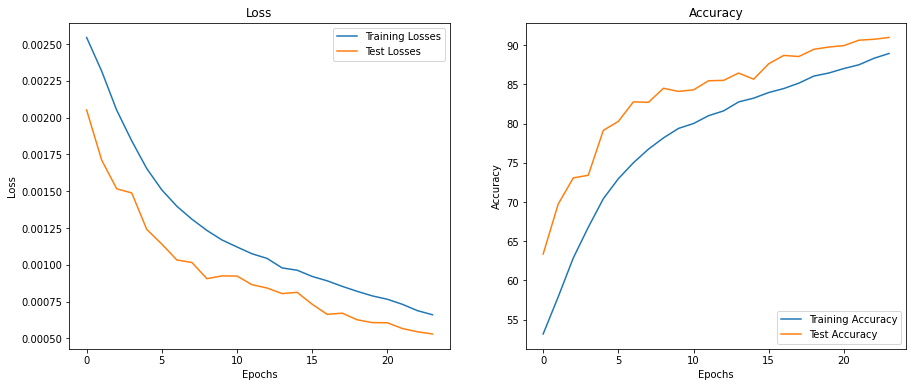

In [ ]:
from Refs.utils import utils

utils.plot_LossAndAcc(train_acc_all, train_losses,test_acc_all,test_losses)

## Test Accuracy

In [ ]:
from Refs import main_ass8

main_ass8.test(model, device, test_loader)

/content/Refs/models/custom_resnet.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)



Test set: Average loss: 0.0005, Accuracy: 9099/10000 (90.99%)



(0.0005341573268175126, 90.99)

## Retrieve data for misclassified images

In [ ]:
from Refs.utils import utils

data_images, pred_labels, target_labels = utils.get_mis_classified_byloader(model, device, test_loader)
print(len(data_images), len(pred_labels), len(target_labels))

901 901 901


## Plot mis classified images

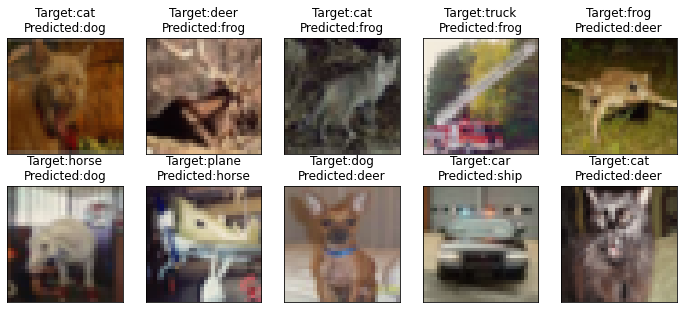

In [ ]:
import matplotlib.pyplot as plt
from Refs.utils import utils
        
utils.plot_misclassified(data_images, target_labels, pred_labels, classes, no_images= 10)

## Gradcam

/content/Refs/models/custom_resnet.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


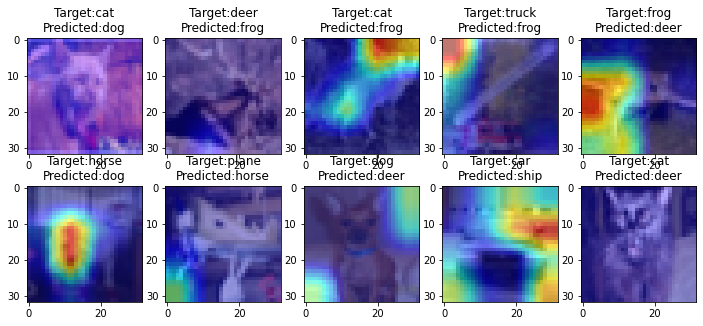

In [ ]:
from Refs.utils import gradcam

gradcam.plot_grad_images(model, [model.layer3], data_images[:10], pred_labels[:10], target_labels[:10], list(range(10)), classes)